# FFN Classification

A notebook to apply an FFN (Feed Forward Neural Network) to classify the flower species type. We will use the the famous Iris dataset (which is now the equivalent of the hellow world dataset in the Data Science World)

Based on
- [Kaggle Notebook for Iris Classiifcation](https://www.kaggle.com/code/mohitchaitanya/simple-iris-dataset-classification-using-pytorch)
- [PyTorch for Iris Dataset](https://github.com/mattsinbot/PyTorch-for-Iris-Dataset) 
- [Iris Classification](https://github.com/yangzhangalmo/pytorch-iris/blob/master/main.py)

**Load, Visualize, Summarise Data**

sklearn comes with Iris dataset. We will load it, and do some basic visualization.
It is always a good idea to "look" at the data before (blindly) running any models.

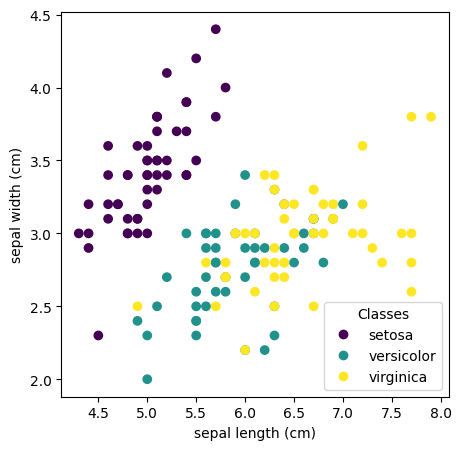

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

We see that, 
1. there are four features, and it is a three class classification problem
2. Using two features (_sepal length_, and _sepal width_), it is clear that, a perceptron will not be able separate _versicolor from _virginica_ (data is not linearly separable) class. 
3. But setosa can be separated from the remaining two.

Let us look at the basic descriptions of the data.

In [2]:

print('feature name',iris.feature_names)
print('features type of data',type(iris.data))
print('features shape',iris.data.shape)
print('feature name',iris.target_names)
print('target type of data',type(iris.target))
print('target shape',iris.target.shape)


feature name ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
features type of data <class 'numpy.ndarray'>
features shape (150, 4)
feature name ['setosa' 'versicolor' 'virginica']
target type of data <class 'numpy.ndarray'>
target shape (150,)


In [3]:
print('target labels',iris.target)

target labels [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Ha. In the original dataset, the data is organized by class. If we naively prepare the mini batches (sequentially), model will only see data corresponding to only one class. This will be pretty problematic to get proper gradient signals. We should shuffle the data s.t diversity in the mini batches is maintained.

**Questions**

Imagine you split the data into two batches. One containing only say class 0, and other contains only class 1. During training, the model sees these two batches cyclically. Will the model ever converge. 

1. Will it converge when the data is linearly separable?
2. Will it converge when the data is not linearly separable?
3. Does having a balanced class representation in every mini batch helps? Which way does it?
4. What will be the impact of learning rate when alternating between sets of samples of one class during gradient descent? 

Let us get back to checking the data, this time, from huggingace datasets itself.
Later down the line, it may be useful to learn how to work with [datasets](https://huggingface.co/docs/datasets/en/index) library from HuggingFace. It has deep integrations with PyTorch.

In [4]:
from datasets import Dataset
import pandas as pd
df = pd.read_csv("hf://datasets/scikit-learn/iris/Iris.csv")
df = pd.DataFrame(df)
df.head()


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Interestingly, the first column is ids., which is not useful for us. May be, a perfect system can simply memory the indices and spit out the correct classes. 

And we need to map the Iris types into numerical codes for models to work with. In the _torch_, we can supply integers representing the classes, and we do not have to explicitly pass one-hot coded labels. 

In [6]:
# transform species to numerics
df.loc[df.Species=='Iris-setosa', 'Target'] = 0
df.loc[df.Species=='Iris-versicolor', 'Target'] = 1
df.loc[df.Species=='Iris-virginica', 'Target'] = 2
print(df.Target.unique())
df.head()

[0. 1. 2.]


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Target
0,1,5.1,3.5,1.4,0.2,Iris-setosa,0.0
1,2,4.9,3.0,1.4,0.2,Iris-setosa,0.0
2,3,4.7,3.2,1.3,0.2,Iris-setosa,0.0
3,4,4.6,3.1,1.5,0.2,Iris-setosa,0.0
4,5,5.0,3.6,1.4,0.2,Iris-setosa,0.0


In [7]:
# drop the Id columns from the dataframe
df.drop(['Id'],axis=1,inplace=True)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,Target
0,5.1,3.5,1.4,0.2,Iris-setosa,0.0
1,4.9,3.0,1.4,0.2,Iris-setosa,0.0
2,4.7,3.2,1.3,0.2,Iris-setosa,0.0
3,4.6,3.1,1.5,0.2,Iris-setosa,0.0
4,5.0,3.6,1.4,0.2,Iris-setosa,0.0


In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df[df.columns[0:4]].values
y = df.Target.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8)

In [9]:
# dip test:  check that data is shuffled
print(y_train)

[2. 1. 2. 2. 0. 0. 0. 2. 1. 2. 0. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 2. 0. 1.
 1. 0. 1. 0. 1. 1.]


**Questions**

Above (visualluy inspecting data) is not a rigorous way (and repeatable way) to test if the data is shuffled (randomly). For numerical labels like integers, in the multi-class or binary class classification problems, which statistical test is suitable to flag if the data grouped?

In [10]:
# scale the features to roughly have zero mean and unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

It is always a good practice to scale the data (features).

1. What might happen if the different features are on different scales? 
2. Does it pose any problems for the optimizer (gradient descent)? 
3. Does it cause any problems w.r.t interpretation of the feature importance?

Suppose instead of 

1. create train, test splits
2. learn the scaling transformation on train data
3. scale both train and test data

``` python
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
```

you do the following

1. learn the scaling transformation on whole data before split
2. and then create train, test splits

``` python
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.8)

```

What happens? Should we do this?

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [12]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

Let us define a FFN (or MLP) with two hidden layers. Suppose $x$ is a $B \times 4$ vector, we have two hidden layers of 64 dimensions each, and we have three outputs (one for each class), then,
$$
h_1 = ReLU(x W_{1} +b_{1}) \\
h_2 = ReLU(h_1 W_{2} +b_{2}) \\
y =  h_2 W_{out} + b_{out} \\
$$

where
$$
x \text{ is } B \times 4 \\
W_{1} \text{ is } 4 \times 64 \\
W_{2} \text{ is } 64 \times 64 \\ 
W_{out} \text{ is } 64 \times 3 \\
b_{1} \text{ is } 1 \times 64 \\
b_{2} \text{ is } 1 \times 64 \\
b_{out} \text{ is } 1 \times 3 \\
y \text{ is } B \times 3 \\
$$

In $xW +b $, $b$ is broadcast over all rows and $B$ is the batch size.

$ReLU(x) = x \text{ if } x \ge 0 \text{ and } 0 \text{ o.w }$

**Question**

What is the total number of parameters if input dimension is $p^{in}$, output dimension is $p^{out}$ and each hidden layer is of size $p^{h}_{i}$ for the i-th hidden layer and there $d$ such layers?

In [13]:
class MLP(nn.Module):
    # define nn
    def __init__(self, input_dim=4, output_dim=3, hidden_dim = [128,64]):
        super(MLP, self).__init__()
        self.h1 = nn.Linear(input_dim, hidden_dim[0])
        self.h2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.out = nn.Linear(hidden_dim[1], output_dim)
        self.relu = nn.ReLU()

    def forward(self, X):
        X = self.relu(self.h1(X))
        X = self.relu(self.h2(X))
        X = self.out(X)
        return X


We have built a Neural Network with one input layer, two hidden layers, and one output layer.

Note, the last output layer is a linear layer. 
Even though we are modeling a 3-class problem, output layer is still linear, and not softmax. Is this fine?

In [14]:
input_dim = 4 # No. of features
output_dim = 3 # No. of outputs
hidden_dim = [64, 64] # No. of perceptrons in 1st hidden layer and 2nd hidden layer
model = MLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim) # instantiate the model

In [15]:
# inspect the model for a given batch size
from torchinfo import summary
summary(model, input_size=(10, 4))


Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [10, 3]                   --
├─Linear: 1-1                            [10, 64]                  320
├─ReLU: 1-2                              [10, 64]                  --
├─Linear: 1-3                            [10, 64]                  4,160
├─ReLU: 1-4                              [10, 64]                  --
├─Linear: 1-5                            [10, 3]                   195
Total params: 4,675
Trainable params: 4,675
Non-trainable params: 0
Total mult-adds (M): 0.05
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03

In [16]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [17]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)


        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()
        
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")

In the above _train_network_ block, we have not used batches. Entire train data is passed at once. So, one epoch is one complete pass through the data.

**Exercise**

Modify the training loop to pass over mini batches.

In [18]:
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)

In [19]:
train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

Epoch 50/1000, Train Loss: 0.0001, Test Loss: 0.1433
Epoch 100/1000, Train Loss: 0.0000, Test Loss: 0.1390
Epoch 150/1000, Train Loss: 0.0000, Test Loss: 0.1403
Epoch 200/1000, Train Loss: 0.0000, Test Loss: 0.1430
Epoch 250/1000, Train Loss: 0.0000, Test Loss: 0.1450
Epoch 300/1000, Train Loss: 0.0000, Test Loss: 0.1467
Epoch 350/1000, Train Loss: 0.0000, Test Loss: 0.1484
Epoch 400/1000, Train Loss: 0.0000, Test Loss: 0.1500
Epoch 450/1000, Train Loss: 0.0000, Test Loss: 0.1514
Epoch 500/1000, Train Loss: 0.0000, Test Loss: 0.1525
Epoch 550/1000, Train Loss: 0.0000, Test Loss: 0.1533
Epoch 600/1000, Train Loss: 0.0000, Test Loss: 0.1540
Epoch 650/1000, Train Loss: 0.0000, Test Loss: 0.1547
Epoch 700/1000, Train Loss: 0.0000, Test Loss: 0.1554
Epoch 750/1000, Train Loss: 0.0000, Test Loss: 0.1562
Epoch 800/1000, Train Loss: 0.0000, Test Loss: 0.1569
Epoch 850/1000, Train Loss: 0.0000, Test Loss: 0.1577
Epoch 900/1000, Train Loss: 0.0000, Test Loss: 0.1584
Epoch 950/1000, Train Loss: 0

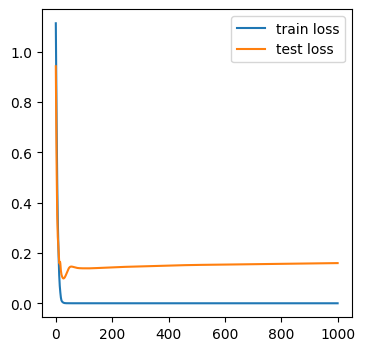

In [20]:
plt.figure(figsize=(4,4))
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [21]:
predictions_train = []
predictions_test =  []
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

In [22]:
print(predictions_train.shape)
print(type(predictions_train))

print(y_train.shape)
print(type(y_train))


torch.Size([30, 3])
<class 'torch.Tensor'>
torch.Size([30])
<class 'torch.Tensor'>


In [23]:
def get_accuracy_multiclass(pred_arr,original_arr):
    if len(pred_arr)!=len(original_arr):
        return False
    pred_arr = pred_arr.numpy()
    original_arr = original_arr.numpy()
    final_pred= []
    # we will get something like this in the pred_arr [32.1680,12.9350,-58.4877]
    # so will be taking the index of that argument which has the highest value here 32.1680 which corresponds to 0th index
    for i in range(len(pred_arr)):
        final_pred.append(np.argmax(pred_arr[i]))
    final_pred = np.array(final_pred)
    count = 0
    #here we are doing a simple comparison between the predicted_arr and the original_arr to get the final accuracy
    for i in range(len(original_arr)):
        if final_pred[i] == original_arr[i]:
            count+=1
    return count/len(final_pred)

Notice that the model predictions were of size _(batch_size, output_dim)_ and we have to take _argmax_ of the model predictions to produce the class labels.  The predictions are in the _logit_ space (recall that the output layer is _linear_ and not _softmax_).

In [24]:
train_acc = get_accuracy_multiclass(predictions_train,y_train)
test_acc  = get_accuracy_multiclass(predictions_test,y_test)
print(f"Training Accuracy: {round(train_acc*100,3)}")
print(f"Test Accuracy: {round(test_acc*100,3)}")

Training Accuracy: 100.0
Test Accuracy: 95.0
